In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit import transpile

sim = QasmSimulator() # making new simulator object

# Loading the IBM Quantum account(s)

provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
from qiskit import QuantumCircuit

# 1. Quantum Fourier Tranform:

Converting computational basis to Fourier basis.

In [ ]:
def myQFT(nqubits):
    circuit = QuantumCircuit(nqubits, name = '  myQFT  ')
    
    for n in range(nqubits): # for nth qubit
        circuit.h(n)
        for m in range(n+1, nqubits): #for all the other qubits
            circuit.cp(np.pi/2**(m-n), m, n)
                        
    return circuit #output is in a reversed order of the input states
                        
myQFT(5).draw()

In [ ]:
n = 3

myQFT5 = myQFT(n)

In [ ]:
qc = QuantumCircuit(n)

qc.x(0)
#qc.x(1)
#qc.x(2)
#qc.x(3)
#qc.x(4)

qc.append(myQFT5, qc.qubits)

In [ ]:
qc.draw()

In [ ]:
ket = Statevector(qc)
#ket.draw()
ket.draw('latex')

In [ ]:
#Use cmd+/ to uncomments lines of code below

#note that the phase does not have observational effects

qc.measure_all()

from qiskit import execute

counts = execute(qc, backend=sim, shots=1000).result().get_counts(qc)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

# 2. Quantum Phase Estimation

We use Inverse Quantum Fourier Transform on the measurement qubits before final measurements

In [7]:
def initialize_qubits(given_circuit, measurement_qubits, target_qubit):

    given_circuit.h(measurement_qubits)
    given_circuit.x(target_qubit)

In [8]:
import numpy as np
pi = np.pi

def unitary_operator(given_circuit, control_qubit, target_qubit, theta):
    
    given_circuit.cu1(2*pi*theta, control_qubit, target_qubit)

In [9]:
def unitary_operator_exponent(given_circuit, control_qubit, target_qubit, theta, exponent):
    
    given_circuit.cu1(2*pi*theta*exponent, control_qubit, target_qubit)

In [10]:
from qiskit.circuit.library import QFT

def apply_iqft(given_circuit, measurement_qubits, n):
     
    given_circuit.append(QFT(n).inverse(), measurement_qubits)

In [11]:
def qpe_program(n, theta):
    
    # Create a quantum circuit on n+1 qubits (n measurement, 1 target)
    qc = QuantumCircuit(n+1, n)
    
    # Initialize the qubits
    initialize_qubits(qc, range(n), n)
    
    # Apply the controlled unitary operators in sequence
    for x in range(n):
        exponent = 2**(n-x-1)
        unitary_operator_exponent(qc, x, n, theta, exponent)
        
    # Apply the inverse quantum Fourier transform
    apply_iqft(qc, range(n), n)
    
    # Measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

n = 5; theta = 0.5
mycircuit = qpe_program(n, theta)
mycircuit.draw(output='text')

/tmp/ipykernel_329/1430307391.py:3: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  given_circuit.cu1(2*pi*theta*exponent, control_qubit, target_qubit)


┌───┐                                             ┌───────┐┌─┐            
q_0: ┤ H ├─■───────────────────────────────────────────┤0      ├┤M├────────────
     ├───┤ │                                           │       │└╥┘┌─┐         
q_1: ┤ H ├─┼─────────■─────────────────────────────────┤1      ├─╫─┤M├─────────
     ├───┤ │         │                                 │       │ ║ └╥┘┌─┐      
q_2: ┤ H ├─┼─────────┼────────■────────────────────────┤2 IQFT ├─╫──╫─┤M├──────
     ├───┤ │         │        │                        │       │ ║  ║ └╥┘┌─┐   
q_3: ┤ H ├─┼─────────┼────────┼────────■───────────────┤3      ├─╫──╫──╫─┤M├───
     ├───┤ │         │        │        │               │       │ ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├─┼─────────┼────────┼────────┼────────■──────┤4      ├─╫──╫──╫──╫─┤M├
     ├───┤ │U1(16π)  │U1(8π)  │U1(4π)  │U1(2π)  │U1(π) └───────┘ ║  ║  ║  ║ └╥┘
q_5: ┤ X ├─■─────────■────────■────────■────────■────────────────╫──╫──╫──╫──╫─
     └───┘                                                       ║  ║  ║  ║  ║ 
c: 5/════════════════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                                 0  1  2  3  4

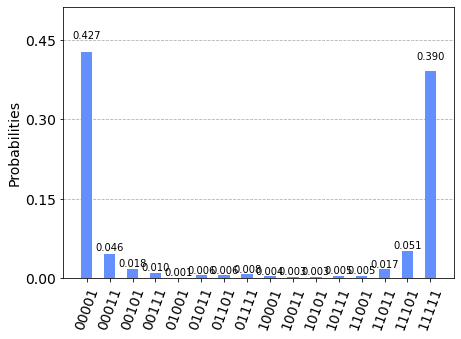

In [12]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [13]:
import operator
highest_probability_outcome = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
measured_theta = int(highest_probability_outcome, 2)/2**n # Phase Estimation gives 2**n times the theta
print("Using %d qubits with theta = %.2f, measured_theta = %.2f." % (n, theta, measured_theta))

Using 5 qubits with theta = 0.50, measured_theta = 0.50.
